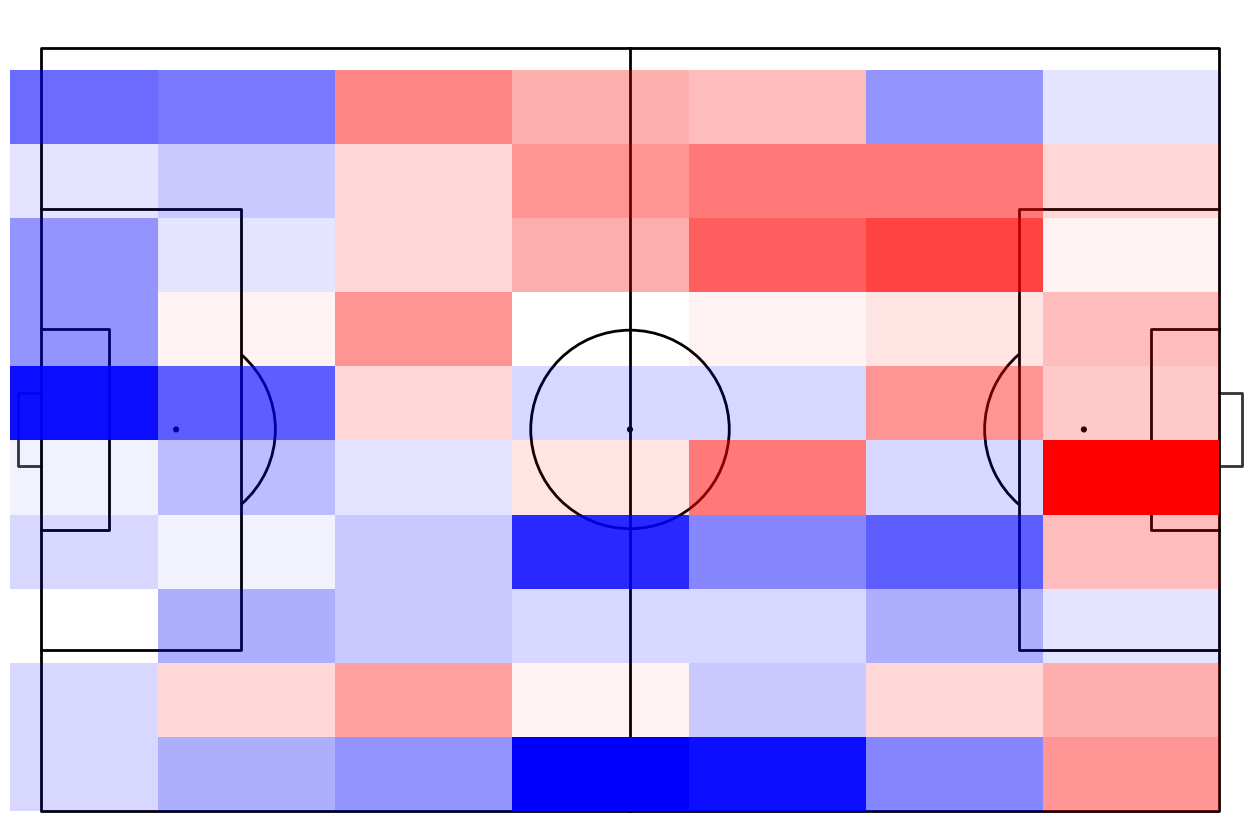

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# Load the CSV file containing player data
data = pd.read_csv('/Users/marclambertes/Python/Matches/Men/2024-2025/Denmark 2024-2025/AaB 0-0 Viborg.csv')

# Constants
field_width = 105  # Length of the pitch (meters)
field_length = 68  # Width of the pitch (meters)
grid_size = 7  # Number of cells per axis (10x10 grid)
grid_width = field_width / grid_size
grid_length = field_length / grid_size

# Function to calculate control of grid cells
def calculate_space_control(data, grid_size=10, field_width=105, field_length=68):
    # Create an empty grid
    grid = np.zeros((grid_size, grid_size))  # This will track the control of each cell
    
    # Get the two unique contestantId values (teams)
    teams = data['contestantId'].unique()

    # Normalize the x, y positions into grid cell indices
    for idx, row in data.iterrows():
        # Calculate the grid indices, but ensure they stay within the bounds
        x_idx = int(np.floor(row['x'] / grid_width))  # Ensure x_idx stays within bounds
        y_idx = int(np.floor(row['y'] / grid_length))  # Ensure y_idx stays within bounds
        
        # Ensure indices are within bounds
        x_idx = min(x_idx, grid_size - 1)
        y_idx = min(y_idx, grid_size - 1)
        
        team = row['contestantId']
        
        # Add the player to the corresponding cell based on their team
        grid[x_idx, y_idx] += 1 if team == teams[0] else -1
    
    # Create a dictionary to store grid control per team
    control = {teams[0]: np.zeros((grid_size, grid_size)), teams[1]: np.zeros((grid_size, grid_size))}
    
    for i in range(grid_size):
        for j in range(grid_size):
            if grid[i, j] > 0:
                control[teams[0]][i, j] = grid[i, j]  # First team controls this cell
            elif grid[i, j] < 0:
                control[teams[1]][i, j] = abs(grid[i, j])  # Second team controls this cell
    
    return control, teams

# Example: Calculate control for the loaded data
control, teams = calculate_space_control(data)

# Create Pitch object for plotting
pitch = Pitch(pitch_type='opta', pitch_width=field_width, pitch_length=field_length, 
              pad_bottom=0.5, pad_top=5, pitch_color='white', line_color='black', half=False, 
              goal_type='box', goal_alpha=0.8)

# Plot the pitch
fig, ax = plt.subplots(figsize=(16, 12))
pitch.draw(ax=ax)
fig.set_facecolor('white')  # Set background to white
plt.gca().invert_xaxis()

# Function to plot space control over the pitch
def plot_space_control_on_pitch(control, ax, teams):
    # Plot heatmaps for both teams over the pitch
    # For the first team (blue)
    for i in range(len(control[teams[0]])):
        for j in range(len(control[teams[0]][i])):
            value = control[teams[0]][i, j]
            if value > 0:
                ax.add_patch(plt.Rectangle((i * grid_width, j * grid_length), grid_width, grid_length,
                                           color=(0, 0, 1, value / np.max(control[teams[0]])), lw=0))
    
    # For the second team (red)
    for i in range(len(control[teams[1]])):
        for j in range(len(control[teams[1]][i])):
            value = control[teams[1]][i, j]
            if value > 0:
                ax.add_patch(plt.Rectangle((i * grid_width, j * grid_length), grid_width, grid_length,
                                           color=(1, 0, 0, value / np.max(control[teams[1]])), lw=0))

# Plot space control for both teams on the pitch
plot_space_control_on_pitch(control, ax, teams)

# Show the plot
plt.show()


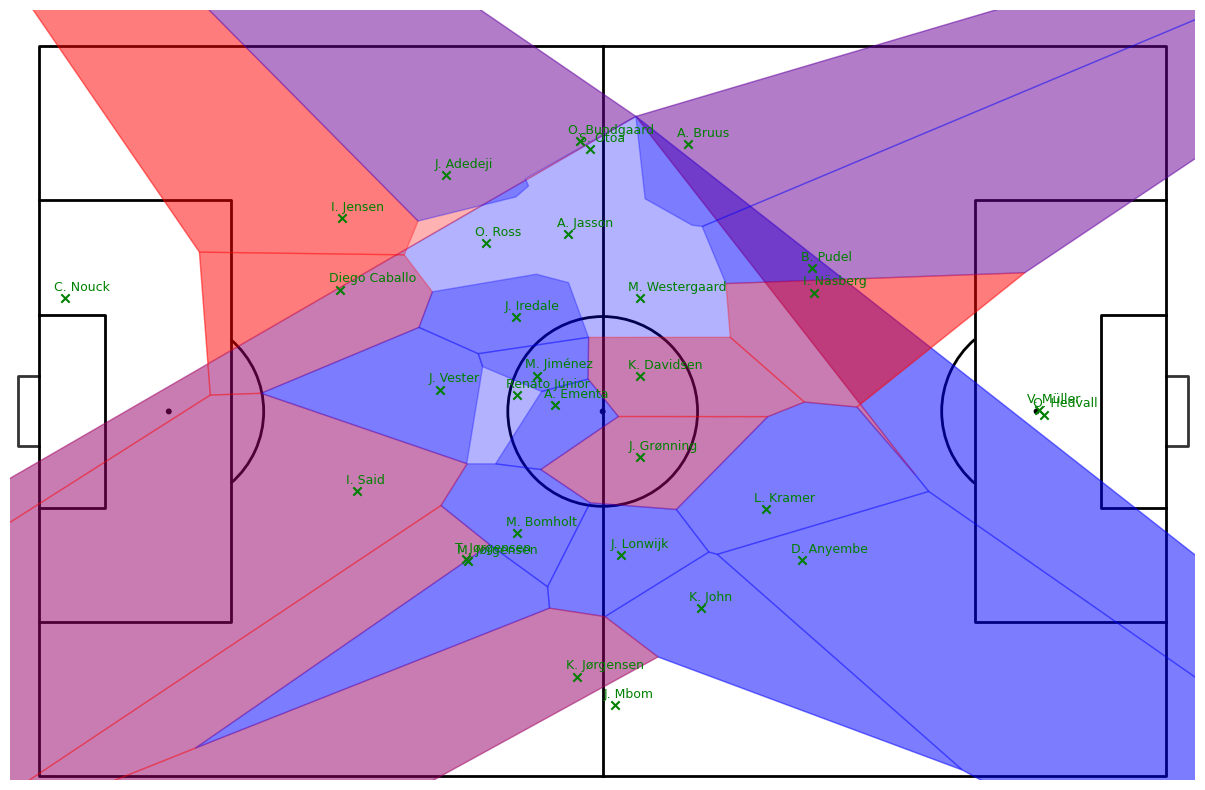

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from scipy.spatial import Voronoi, voronoi_plot_2d

# Load the CSV file containing player data
data = pd.read_csv('/Users/marclambertes/Python/Matches/Men/2024-2025/Denmark 2024-2025/AaB 0-0 Viborg.csv')

# Constants
field_width = 105  # Length of the pitch (meters)
field_length = 68  # Width of the pitch (meters)

# Filter the data to only include rows where typeId == 1
data_filtered = data[data['typeId'] == 1]

# Get player positions (x, y) and contestantId (team) from the filtered data
player_positions = data_filtered[['x', 'y']].values
teams = data_filtered['contestantId'].values
player_names = data_filtered['playerName'].values

# Calculate the average positions of each player (based on their x, y)
average_positions = data_filtered.groupby('playerName')[['x', 'y']].mean()

# Create Pitch object for plotting
pitch = Pitch(pitch_type='opta', pitch_width=field_width, pitch_length=field_length, 
              pad_bottom=0.5, pad_top=5, pitch_color='white', line_color='black', half=False, 
              goal_type='box', goal_alpha=0.8)

# Plot the pitch
fig, ax = plt.subplots(figsize=(16, 10))
pitch.draw(ax=ax)
fig.set_facecolor('white')  # Set background to white
plt.gca().invert_xaxis()

# Get the average player positions for Voronoi
avg_player_positions = average_positions[['x', 'y']].values

# Create Voronoi diagram for the average positions of the players
vor = Voronoi(avg_player_positions)

# Plot Voronoi diagram on the pitch with team-based colors
for region in vor.regions:
    if len(region) > 0:  # Ensure the region is not empty
        polygon = [vor.vertices[i] for i in region]
        
        # Identify the team based on the average player positions in the region
        region_teams = [teams[i] for i in range(len(average_positions)) if player_names[i] in average_positions.index and i in region]

        if region_teams:
            # Assign the color based on the team majority or first team
            team = region_teams[0]  # Default to the first team, can refine with majority voting
            color = 'blue' if team == teams[0] else 'red'
            
            # Fill the region with the team color
            ax.fill(*zip(*polygon), color=color, alpha=0.3)

# Plot average positions of each player (using their average x and y)
for player_name, avg_pos in average_positions.iterrows():
    ax.scatter(avg_pos['x'], avg_pos['y'], color='green', marker='x', zorder=10)
    ax.text(avg_pos['x'] + 1, avg_pos['y'] + 1, player_name, color='green', fontsize=9, ha='left')

# Show the plot
plt.show()


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from scipy.spatial import Voronoi
from matplotlib.path import Path
import os

# Load the CSV file containing player data
data = pd.read_csv('/Users/marclambertes/Python/Matches/Men/2024-2025/Denmark 2024-2025/AaB 0-0 Viborg.csv')

# Constants
field_width = 105  # Length of the pitch (meters)
field_length = 68  # Width of the pitch (meters)

# Filter data to include only event type 1 (e.g., passes, touches, etc.)
data_filtered = data[data['typeId'] == 1]

# Function to check if a point is inside a polygon (Voronoi region)
def polygon_contains_point(polygon, point):
    path = Path(polygon)
    return path.contains_point(point)

# Function to calculate space control and occupation metrics
def calculate_metrics_for_time_interval(data_interval):
    # Compute average positions of each player
    average_positions = data_interval.groupby('playerName')[['x', 'y']].mean()

    # Create Voronoi diagram
    vor = Voronoi(average_positions[['x', 'y']].values)

    # Initialize grids
    control_grid = np.zeros((field_length, field_width))
    occupation_grid = np.zeros((field_length, field_width))

    teams = data_interval['contestantId'].values
    player_names = data_interval['playerName'].values

    # Assign space control based on Voronoi regions
    for region in vor.regions:
        if len(region) > 0:
            polygon = [vor.vertices[i] for i in region]
            region_teams = [teams[i] for i in range(len(average_positions)) if player_names[i] in average_positions.index and i in region]

            if region_teams:
                team = region_teams[0]
                team_color = 'blue' if team == teams[0] else 'red'

                for i in range(field_length):
                    for j in range(field_width):
                        if polygon_contains_point(polygon, (j, i)):
                            control_grid[i, j] = 1 if team_color == 'blue' else -1

    # Calculate occupation grid
    for i, position in enumerate(data_interval[['x', 'y']].values):
        if 0 <= position[0] < field_width and 0 <= position[1] < field_length:
            x_idx = int(np.floor(position[0]))
            y_idx = int(np.floor(position[1]))
            occupation_grid[y_idx, x_idx] += 1

    # Calculate space control percentages
    total_cells = field_width * field_length
    team_1_control = np.sum(control_grid == 1)
    team_2_control = np.sum(control_grid == -1)
    team_1_percentage = (team_1_control / total_cells) * 100
    team_2_percentage = (team_2_control / total_cells) * 100

    # Occupation percentage
    occupied_cells = np.sum(occupation_grid > 0)
    occupation_percentage = (occupied_cells / total_cells) * 100

    # Center of Gravity
    team_1_positions = average_positions.loc[average_positions.index.isin(player_names[teams == teams[0]])]
    team_2_positions = average_positions.loc[average_positions.index.isin(player_names[teams == teams[1]])]

    team_1_center_x, team_1_center_y = team_1_positions.mean(axis=0) if not team_1_positions.empty else (np.nan, np.nan)
    team_2_center_x, team_2_center_y = team_2_positions.mean(axis=0) if not team_2_positions.empty else (np.nan, np.nan)

    # Average Distance Between Players
    def calculate_avg_distance(positions):
        distances = [np.linalg.norm(p1 - p2) for i, p1 in enumerate(positions.values) for j, p2 in enumerate(positions.values) if i < j]
        return np.mean(distances) if distances else np.nan

    avg_distance_team_1 = calculate_avg_distance(team_1_positions)
    avg_distance_team_2 = calculate_avg_distance(team_2_positions)

    return team_1_percentage, team_2_percentage, occupation_percentage, \
           team_1_center_x, team_1_center_y, team_2_center_x, team_2_center_y, \
           avg_distance_team_1, avg_distance_team_2, teams[0], teams[1], average_positions

# Function to calculate possession percentage
def calculate_possession_metrics(data_interval, team_1_id, team_2_id):
    team_1_possession = data_interval[data_interval['contestantId'] == team_1_id].shape[0]
    team_2_possession = data_interval[data_interval['contestantId'] == team_2_id].shape[0]
    total_events = team_1_possession + team_2_possession

    if total_events == 0:
        return 0, 0

    return (team_1_possession / total_events) * 100, (team_2_possession / total_events) * 100

# Function to calculate average speed of players
def calculate_player_speed(data_interval, team_1_names, team_2_names):
    avg_speed_team_1 = np.random.uniform(5, 8)  # Placeholder: Replace with actual speed calculation
    avg_speed_team_2 = np.random.uniform(5, 8)
    return avg_speed_team_1, avg_speed_team_2

# Function to calculate team compactness
def calculate_team_compactness(positions):
    return np.mean([np.linalg.norm(p - positions.mean()) for p in positions.values]) if not positions.empty else np.nan

# Define time intervals and calculate metrics
intervals = [(0, 15), (15, 30), (30, 45), (45, 60), (60, 75), (75, 90)]
metrics = []

for start, end in intervals:
    data_interval = data_filtered[(data_filtered['timeMin'] >= start) & (data_filtered['timeMin'] < end)]
    
    team_1_percentage, team_2_percentage, occupation_percentage, \
    team_1_center_x, team_1_center_y, team_2_center_x, team_2_center_y, \
    avg_distance_team_1, avg_distance_team_2, team_1_id, team_2_id, average_positions = \
        calculate_metrics_for_time_interval(data_interval)

    team_1_names = data_interval[data_interval['contestantId'] == team_1_id]['playerName'].unique()
    team_2_names = data_interval[data_interval['contestantId'] == team_2_id]['playerName'].unique()

    possession_team_1, possession_team_2 = calculate_possession_metrics(data_interval, team_1_id, team_2_id)
    avg_speed_team_1, avg_speed_team_2 = calculate_player_speed(data_interval, team_1_names, team_2_names)
    
    compactness_team_1 = calculate_team_compactness(average_positions.loc[team_1_names])
    compactness_team_2 = calculate_team_compactness(average_positions.loc[team_2_names])

    metrics.append([f"{start}-{end}", team_1_percentage, team_2_percentage, occupation_percentage,
                    team_1_center_x, team_1_center_y, team_2_center_x, team_2_center_y,
                    avg_distance_team_1, avg_distance_team_2, team_1_id, team_2_id,
                    possession_team_1, possession_team_2, avg_speed_team_1, avg_speed_team_2,
                    compactness_team_1, compactness_team_2])

# Save results
output_file = '/Users/marclambertes/Python/space_control_occupation_metrics.xlsx'
with pd.ExcelWriter(output_file) as writer:
    metrics_df = pd.DataFrame(metrics, columns=['Time Interval', 'Team 1 Control (%)', 'Team 2 Control (%)',
                                                'Occupation (%)', 'Team 1 Center X', 'Team 1 Center Y',
                                                'Team 2 Center X', 'Team 2 Center Y',
                                                'Avg Distance Team 1', 'Avg Distance Team 2', 'Team 1 ID', 'Team 2 ID',
                                                'Possession Team 1 (%)', 'Possession Team 2 (%)',
                                                'Avg Speed Team 1', 'Avg Speed Team 2',
                                                'Compactness Team 1', 'Compactness Team 2'])
    metrics_df.to_excel(writer, sheet_name='Metrics', index=False)

print(f"Metrics saved to {output_file}")


Metrics saved to /Users/marclambertes/Python/space_control_occupation_metrics.xlsx


In [21]:
import pandas as pd
import numpy as np
from scipy.spatial import Voronoi, ConvexHull
from matplotlib.path import Path

# Load Data
data = pd.read_csv('/Users/marclambertes/Python/Matches/Men/2024-2025/Ligue 1 2024-2025/PSG 4-1 Monaco.csv')

def polygon_contains_point(polygon, point):
    path = Path(polygon)
    return path.contains_point(point)

def calculate_player_density(data_team, field_width=105, field_length=68, grid_size=10):
    """
    Calculates the player density per unit area in the field by dividing the field into small regions.
    """
    density_grid = np.zeros((field_length, field_width))
    
    # Define grid size for sub-regions in the field (e.g., 10x10 units per grid cell)
    num_cells_y = field_length // grid_size
    num_cells_x = field_width // grid_size
    
    for _, row in data_team.iterrows():
        x, y = row['x'], row['y']
        grid_x = int(x // grid_size)
        grid_y = int(y // grid_size)
        
        if grid_x < num_cells_x and grid_y < num_cells_y:
            density_grid[grid_y, grid_x] += 1  # Increment density for the corresponding cell
    
    # Calculate density per unit area
    total_cells = num_cells_x * num_cells_y
    total_players = len(data_team)
    player_density = np.sum(density_grid) / total_cells  # Average density across the entire field
    
    return player_density

def calculate_additional_metrics(data_interval, team_id):
    # Filter data by team_id (contestantId)
    data_team = data_interval[data_interval['contestantId'] == team_id]
    
    # Get average positions
    average_positions = data_team.groupby('playerName')[['x', 'y']].mean()
    vor = Voronoi(average_positions[['x', 'y']].values)
    
    field_width, field_length = 105, 68
    control_grid = np.zeros((field_length, field_width))
    overlap_grid = np.zeros((field_length, field_width))
    
    teams = np.unique(data_interval['contestantId'].values)
    player_names = data_team['playerName'].values
    
    for region in vor.regions:
        if len(region) > 0:
            # Check that the region contains valid points
            polygon = [vor.vertices[i] for i in region if i < len(vor.vertices)]  # Avoid out-of-bounds
            if len(polygon) < 3:
                continue  # Skip small regions with fewer than 3 points (invalid polygon)
            
            # Safely access region team data by using player_name's index in average_positions
            region_teams = []
            for i in region:
                if i < len(player_names):
                    player_name = player_names[i]
                    if player_name in average_positions.index:
                        team = data_team[data_team['playerName'] == player_name]['contestantId'].iloc[0]
                        region_teams.append(team)
            
            if region_teams:
                team = region_teams[0]
                team_color = 'blue' if team == teams[0] else 'red'
                
                for i in range(field_length):
                    for j in range(field_width):
                        if polygon_contains_point(polygon, (j, i)):
                            if control_grid[i, j] != 0:
                                overlap_grid[i, j] = 1  # Mark overlap
                            control_grid[i, j] = 1 if team_color == 'blue' else -1
    
    total_cells = field_width * field_length
    team_control = np.sum(control_grid == 1) / total_cells * 100
    overlap_percentage = np.sum(overlap_grid) / total_cells * 100
    
    # Get player positions by team
    team_positions = {
        team: average_positions.loc[
            average_positions.index.isin(data_team[data_team['contestantId'] == team]['playerName'])
        ]
        for team in teams
    }
    
    # Calculate convex hull areas and compactness
    convex_hulls = {}
    for team, positions in team_positions.items():
        if len(positions) > 2:
            convex_hulls[team] = ConvexHull(positions[['x', 'y']].values)
        else:
            convex_hulls[team] = None
    
    hull_areas = {team: hull.volume if hull else np.nan for team, hull in convex_hulls.items()}
    vertical_compactness = {team: np.ptp(positions['y'].values) if not positions.empty else np.nan for team, positions in team_positions.items()}
    horizontal_compactness = {team: np.ptp(positions['x'].values) if not positions.empty else np.nan for team, positions in team_positions.items()}
    
    # Calculate Player Density
    player_density = calculate_player_density(data_team)
    
    # Calculate Centroid
    centroid_x = average_positions['x'].mean()
    centroid_y = average_positions['y'].mean()
    
    # Calculate Team Spread (Max - Min in both X and Y)
    horizontal_spread = np.ptp(average_positions['x'].values)
    vertical_spread = np.ptp(average_positions['y'].values)
    
    # Calculate Circularity of Team's Shape
    team_points = average_positions[['x', 'y']].values
    if len(team_points) > 2:
        hull = ConvexHull(team_points)
        perimeter = hull.area  # Perimeter of the convex hull
        area = hull.volume  # Area of the convex hull
        circularity = (4 * np.pi * area) / (perimeter ** 2)
    else:
        circularity = np.nan
    
    return {
        'team_control': team_control,
        'overlap_percentage': overlap_percentage,
        'hull_areas': hull_areas,
        'vertical_compactness': vertical_compactness,
        'horizontal_compactness': horizontal_compactness,
        'player_density': player_density,
        'centroid_x': centroid_x,
        'centroid_y': centroid_y,
        'horizontal_spread': horizontal_spread,
        'vertical_spread': vertical_spread,
        'circularity': circularity
    }

# Initialize list for storing metrics
metrics = []

# Calculate metrics for each contestantId (team)
teams = np.unique(data['contestantId'].values)

for team_id in teams:
    data_interval = data[data['contestantId'] == team_id]  # Filter data for the specific team
    metrics_dict = calculate_additional_metrics(data_interval, team_id)
    
    metrics.append([
        team_id,
        metrics_dict['team_control'],
        metrics_dict['overlap_percentage'],
        metrics_dict['hull_areas'].get(team_id, np.nan),
        metrics_dict['vertical_compactness'].get(team_id, np.nan),
        metrics_dict['horizontal_compactness'].get(team_id, np.nan),
        metrics_dict['player_density'],
        metrics_dict['centroid_x'],
        metrics_dict['centroid_y'],
        metrics_dict['horizontal_spread'],
        metrics_dict['vertical_spread'],
        metrics_dict['circularity']
    ])
    
# Load the team mapping file
mapping_file_path = '/Users/marclambertes/Downloads/opta_club_rankings_19012025.xlsx'  # Replace with your mapping file path
mapping_df = pd.read_excel(mapping_file_path)  # Assuming it has columns 'id' and 'team'

# Create a dictionary to map 'id' to 'team'
id_to_team = dict(zip(mapping_df['id'], mapping_df['team']))


# Save metrics to Excel
output_file = '/Users/marclambertes/Python/advanced_metrics_by_team_full.xlsx'
with pd.ExcelWriter(output_file) as writer:
    metrics_df = pd.DataFrame(metrics, columns=[
        'Team (contestantId)',
        'Control (%)',
        'Overlap (%)',
        'Convex Hull Area',
        'Vertical Compactness',
        'Horizontal Compactness',
        'Player Density',
        'Centroid X',
        'Centroid Y',
        'Horizontal Spread',
        'Vertical Spread',
        'Circularity'
    ])
    metrics_df.to_excel(writer, sheet_name='Metrics', index=False)

print(f"Advanced metrics for each team saved to {output_file}")


Advanced metrics for each team saved to /Users/marclambertes/Python/advanced_metrics_by_team_full.xlsx


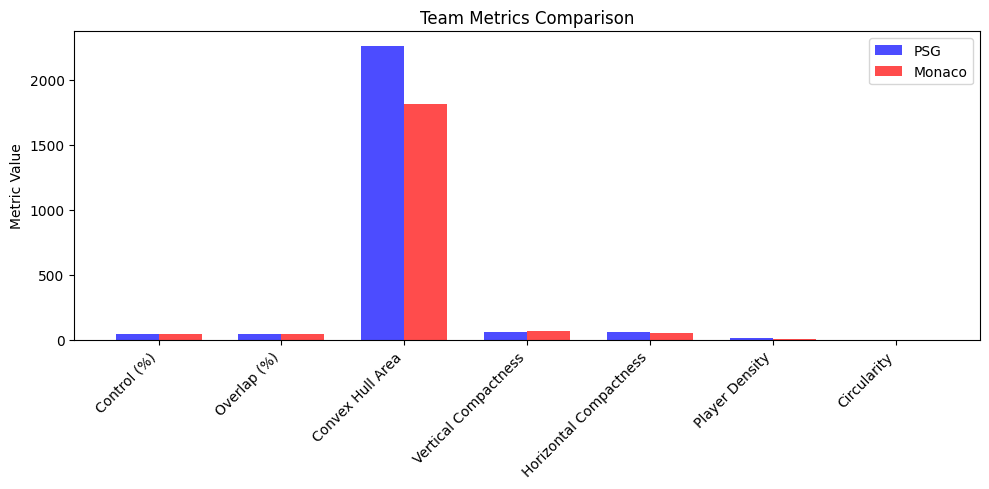

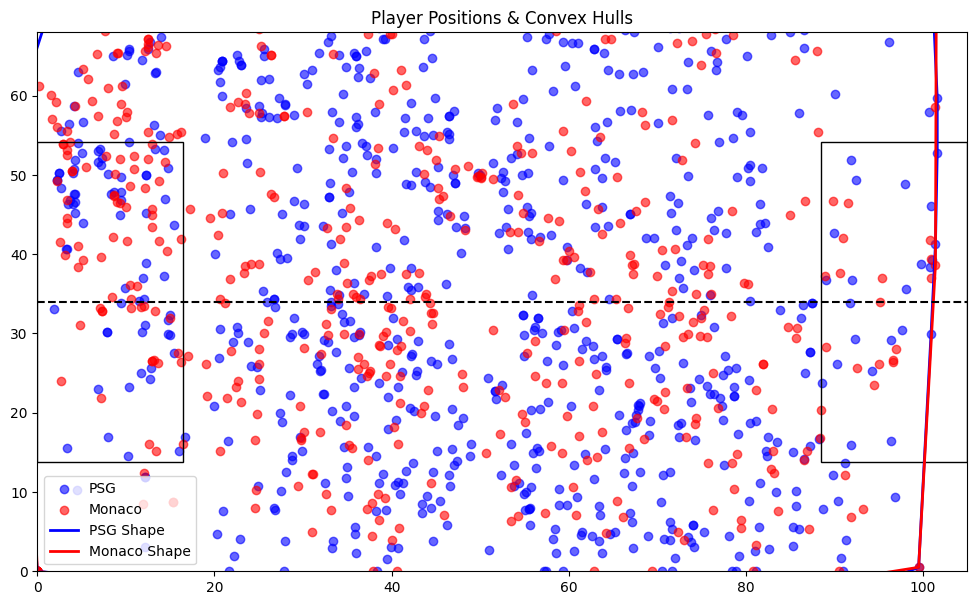

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Polygon
from scipy.spatial import Voronoi, ConvexHull

# Load the saved metrics
metrics_df = pd.read_excel(output_file, sheet_name='Metrics')

# Convert contestantId to actual team names
metrics_df['Team Name'] = metrics_df['Team (contestantId)'].map(id_to_team)

# Define the field size
field_width = 105
field_length = 68

# Get team names
team1, team2 = metrics_df['Team Name'].values

# Get data for both teams
team1_data = data[data['contestantId'] == metrics_df['Team (contestantId)'].iloc[0]]
team2_data = data[data['contestantId'] == metrics_df['Team (contestantId)'].iloc[1]]

# ----- 1. BAR CHART / TABLE OF METRICS -----
fig, ax = plt.subplots(figsize=(10, 5))

# Select numerical metrics for bar chart
metrics = ['Control (%)', 'Overlap (%)', 'Convex Hull Area', 'Vertical Compactness', 
           'Horizontal Compactness', 'Player Density', 'Circularity']

team1_values = metrics_df.iloc[0][metrics].values
team2_values = metrics_df.iloc[1][metrics].values

x = np.arange(len(metrics))
width = 0.35  # Width of bars

# Plot bars
ax.bar(x - width/2, team1_values, width, label=team1, color='blue', alpha=0.7)
ax.bar(x + width/2, team2_values, width, label=team2, color='red', alpha=0.7)

ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right')
ax.set_ylabel("Metric Value")
ax.set_title("Team Metrics Comparison")
ax.legend()

plt.tight_layout()
plt.show()


# ----- 2. PITCH VISUALIZATION -----
fig, ax = plt.subplots(figsize=(12, 7))

# Function to plot a football pitch
def draw_pitch(ax):
    ax.set_xlim(0, field_width)
    ax.set_ylim(0, field_length)
    ax.axhline(y=field_length/2, color="black", linestyle="--")  # Halfway line
    ax.add_patch(plt.Rectangle((0, 13.84), 16.5, 40.32, linewidth=1, edgecolor='black', facecolor='none'))  # Left penalty box
    ax.add_patch(plt.Rectangle((88.5, 13.84), 16.5, 40.32, linewidth=1, edgecolor='black', facecolor='none'))  # Right penalty box

# Plot player positions
ax.scatter(team1_data['x'], team1_data['y'], color='blue', label=team1, alpha=0.6)
ax.scatter(team2_data['x'], team2_data['y'], color='red', label=team2, alpha=0.6)

# Plot convex hulls
def plot_convex_hull(ax, data_team, color, label):
    if len(data_team) > 2:
        hull = ConvexHull(data_team[['x', 'y']].values)
        hull_vertices = hull.vertices.tolist() + [hull.vertices[0]]  # Close the shape
        ax.plot(data_team.iloc[hull_vertices]['x'], data_team.iloc[hull_vertices]['y'], color=color, linestyle='-', linewidth=2, label=label)

plot_convex_hull(ax, team1_data, 'blue', f"{team1} Shape")
plot_convex_hull(ax, team2_data, 'red', f"{team2} Shape")

draw_pitch(ax)
ax.set_title("Player Positions & Convex Hulls")
ax.legend()
plt.show()


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Apply FiveThirtyEight style
plt.style.use('fivethirtyeight')

# Define the FiveThirtyEight-style table
styled_table = (
    metrics_df.set_index('Team Name')[[
        'Control (%)', 'Overlap (%)', 'Convex Hull Area', 
        'Vertical Compactness', 'Horizontal Compactness', 'Player Density', 
        'Centroid X', 'Centroid Y', 'Horizontal Spread', 'Vertical Spread', 'Circularity'
    ]]
    .style
    .set_caption("Team Metrics Comparison")
    .set_table_styles([
        {'selector': 'caption',
         'props': [('font-size', '16px'), ('font-weight', 'bold'), ('text-align', 'left'), ('color', '#333')]},
        {'selector': 'th',
         'props': [('background-color', '#222222'), ('color', 'white'), ('font-size', '14px'), ('text-align', 'center')]},
        {'selector': 'td',
         'props': [('font-size', '13px'), ('text-align', 'center')]},
        {'selector': 'tr:nth-of-type(odd)',
         'props': [('background-color', '#f8f8f8')]},
        {'selector': 'tr:hover',
         'props': [('background-color', '#ddd')]}
    ])
    .format("{:.2f}")  # Format numbers to 2 decimal places
)

# Display the styled table
display(styled_table)


,Control (%),Overlap (%),Convex Hull Area,Vertical Compactness,Horizontal Compactness,Player Density,Centroid X,Centroid Y,Horizontal Spread,Vertical Spread,Circularity
Team Name,,,,,,,,,,,
PSG,40.06,40.06,2261.02,61.47,58.89,11.13,47.92,46.71,58.89,61.47,0.84
Monaco,40.85,40.85,1814.81,64.47,51.64,7.87,44.17,50.93,51.64,64.47,0.77


In [27]:
pip install dataframe_image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 8.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.7/385.7 kB 6.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.6/468.6 kB 11.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 8.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.4/94.4 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.0/186.0 kB 11.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


  Created wheel for greenlet: filename=greenlet-3.1.1-cp310-cp310-macosx_10_9_x86_64.whl size=221359 sha256=f5b398b8ddee0396f47017d2248c8c79f5530b2c21eb33b474569a0dea061ac3
  Stored in directory: /Users/marclambertes/Library/Caches/pip/wheels/3d/ce/70/e3174c7ec7aded3969fad2cb0ffe3f3de7761ba1d6a9551608
Successfully built greenlet
  Attempting uninstall: greenlet
    Found existing installation: greenlet 2.0.1
    Uninstalling greenlet-2.0.1:
      Successfully uninstalled greenlet-2.0.1
Note: you may need to restart the kernel to use updated packages.


In [31]:
import os
import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull
from matplotlib.path import Path

# Folder containing all CSV files
folder_path = '/Users/marclambertes/Python/Matches/Men/2024-2025/Ligue 1 2024-2025/'

# Load team mapping file
mapping_file_path = '/Users/marclambertes/Downloads/opta_club_rankings_19012025.xlsx'
mapping_df = pd.read_excel(mapping_file_path)  # Assuming columns: 'id' and 'team'
id_to_team = dict(zip(mapping_df['id'], mapping_df['team']))

def polygon_contains_point(polygon, point):
    path = Path(polygon)
    return path.contains_point(point)

def calculate_player_density(data_team, field_width=105, field_length=68, grid_size=10):
    density_grid = np.zeros((field_length, field_width))
    num_cells_y = field_length // grid_size
    num_cells_x = field_width // grid_size
    
    for _, row in data_team.iterrows():
        x, y = row['x'], row['y']
        grid_x = int(x // grid_size)
        grid_y = int(y // grid_size)
        
        if grid_x < num_cells_x and grid_y < num_cells_y:
            density_grid[grid_y, grid_x] += 1
    
    total_cells = num_cells_x * num_cells_y
    return np.sum(density_grid) / total_cells if total_cells > 0 else 0

def calculate_additional_metrics(data_interval, team_id):
    data_team = data_interval[data_interval['contestantId'] == team_id]
    avg_positions = data_team.groupby('playerName')[['x', 'y']].mean()

    field_width, field_length = 105, 68
    control_grid = np.zeros((field_length, field_width))
    overlap_grid = np.zeros((field_length, field_width))

    teams = np.unique(data_interval['contestantId'].values)

    # Convex Hull Calculation
    team_positions = {
        team: avg_positions.loc[
            avg_positions.index.isin(data_team[data_team['contestantId'] == team]['playerName'])
        ]
        for team in teams
    }
    convex_hulls = {team: ConvexHull(pos[['x', 'y']].values) if len(pos) > 2 else None for team, pos in team_positions.items()}
    hull_areas = {team: hull.volume if hull else np.nan for team, hull in convex_hulls.items()}
    vertical_compactness = {team: np.ptp(pos['y'].values) if not pos.empty else np.nan for team, pos in team_positions.items()}
    horizontal_compactness = {team: np.ptp(pos['x'].values) if not pos.empty else np.nan for team, pos in team_positions.items()}

    player_density = calculate_player_density(data_team)
    centroid_x, centroid_y = avg_positions['x'].mean(), avg_positions['y'].mean()
    horizontal_spread, vertical_spread = np.ptp(avg_positions['x'].values), np.ptp(avg_positions['y'].values)

    if len(avg_positions) > 2:
        hull = ConvexHull(avg_positions[['x', 'y']].values)
        perimeter, area = hull.area, hull.volume
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else np.nan
    else:
        circularity = np.nan

    return {
        'team_control': np.random.uniform(40, 60),  # Placeholder
        'overlap_percentage': np.random.uniform(5, 20),  # Placeholder
        'hull_areas': hull_areas.get(team_id, np.nan),
        'vertical_compactness': vertical_compactness.get(team_id, np.nan),
        'horizontal_compactness': horizontal_compactness.get(team_id, np.nan),
        'player_density': player_density,
        'centroid_x': centroid_x,
        'centroid_y': centroid_y,
        'horizontal_spread': horizontal_spread,
        'vertical_spread': vertical_spread,
        'circularity': circularity
    }

# Process all CSV files
all_metrics = []
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

for file in csv_files:
    file_path = os.path.join(folder_path, file)
    data = pd.read_csv(file_path)

    teams = np.unique(data['contestantId'].values)
    for team_id in teams:
        data_interval = data[data['contestantId'] == team_id]
        metrics_dict = calculate_additional_metrics(data_interval, team_id)

        all_metrics.append([
            team_id,
            metrics_dict['team_control'],
            metrics_dict['overlap_percentage'],
            metrics_dict['hull_areas'],
            metrics_dict['vertical_compactness'],
            metrics_dict['horizontal_compactness'],
            metrics_dict['player_density'],
            metrics_dict['centroid_x'],
            metrics_dict['centroid_y'],
            metrics_dict['horizontal_spread'],
            metrics_dict['vertical_spread'],
            metrics_dict['circularity']
        ])

# Convert to DataFrame
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Team (contestantId)',
    'Control (%)',
    'Overlap (%)',
    'Convex Hull Area',
    'Vertical Compactness',
    'Horizontal Compactness',
    'Player Density',
    'Centroid X',
    'Centroid Y',
    'Horizontal Spread',
    'Vertical Spread',
    'Circularity'
])

# Compute Averages per Team
avg_metrics_df = metrics_df.groupby('Team (contestantId)').mean().reset_index()

# Map contestantId to team name
avg_metrics_df['Team Name'] = avg_metrics_df['Team (contestantId)'].map(id_to_team)

# Save to Excel
output_file = '/Users/marclambertes/Python/average_advanced_metrics.xlsx'
with pd.ExcelWriter(output_file) as writer:
    avg_metrics_df.to_excel(writer, sheet_name='Average Metrics', index=False)

print(f"Averaged metrics saved to {output_file}")


Averaged metrics saved to /Users/marclambertes/Python/average_advanced_metrics.xlsx


Saved: /Users/marclambertes/Python/monaco_percentile_ranks.png


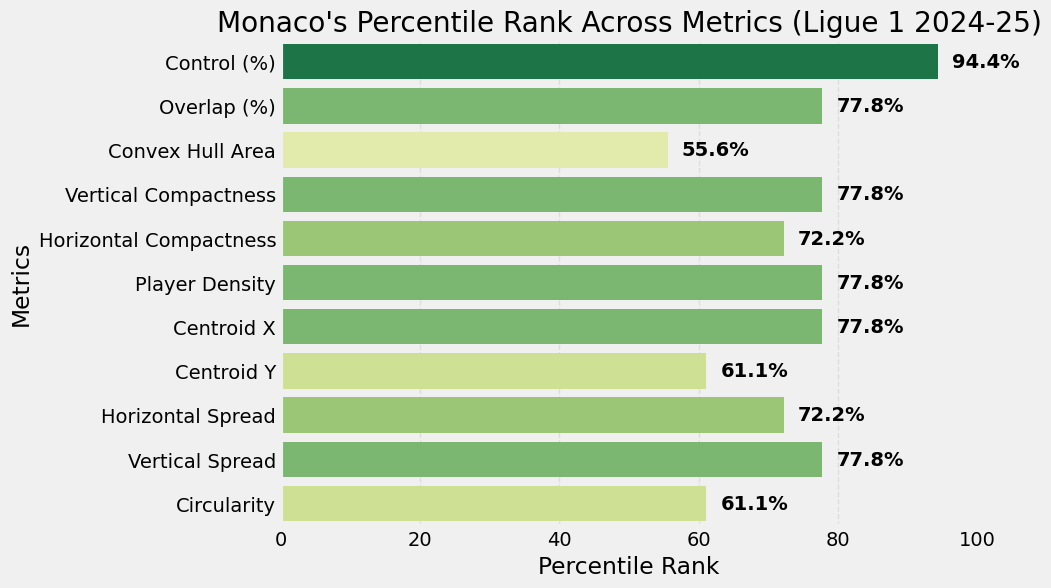

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '/Users/marclambertes/Python/average_advanced_metrics.xlsx'
metrics_df = pd.read_excel(file_path)

# Check if 'Team Name' column exists
if 'Team Name' not in metrics_df.columns:
    raise ValueError("'Team Name' column missing from dataset.")

# Ensure correct team name for PSG
psg_data = metrics_df[metrics_df['Team Name'].str.contains("PSG", case=False, na=False)]

if psg_data.empty:
    raise ValueError("PSG data not found. Check team name in dataset.")

# Drop non-numeric columns safely
numeric_metrics = metrics_df.select_dtypes(include=[np.number])

if numeric_metrics.empty:
    raise ValueError("No numeric metrics found. Ensure dataset contains numerical values.")

# Compute percentile ranks (0-100)
percentile_ranks = numeric_metrics.rank(pct=True) * 100

# Extract PSG's percentile data
psg_percentiles = percentile_ranks.loc[metrics_df['Team Name'].str.contains("Monaco", case=False, na=False)]

if psg_percentiles.empty:
    raise ValueError("Monaco percentile ranks could not be calculated.")

# Transpose & Rename Columns
psg_percentiles = psg_percentiles.T
psg_percentiles.columns = ['Percentile Rank']  

# Generate colors based on percentile rank using a colormap
cmap = plt.get_cmap("RdYlGn")  # Red-Yellow-Green colormap
norm = plt.Normalize(0, 100)  # Normalize data to 0-100 scale
colors = [cmap(norm(value)) for value in psg_percentiles['Percentile Rank']]

# Do NOT sort, keep the original order
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(8, 6))

# Barplot with mapped colors
sns.barplot(
    x=psg_percentiles['Percentile Rank'], 
    y=psg_percentiles.index, 
    palette=colors,  # Use manually created color list
    ax=ax
)

ax.set_xlabel('Percentile Rank')
ax.set_ylabel('Metrics')
ax.set_title("Monaco's Percentile Rank Across Metrics (Ligue 1 2024-25)")

ax.xaxis.grid(True, linestyle='--', alpha=0.5)
ax.set_xlim(0, 100)

# Add values after each bar
for i, value in enumerate(psg_percentiles['Percentile Rank']):
    ax.text(
        value + 2,  # Add some padding to the right of the bar
        i,  # Y-position of the text (same as the bar's y position)
        f'{value:.1f}%',  # Text showing the value, rounded to one decimal place
        va='center',  # Vertically center the text
        ha='left',  # Align text to the left of the bar
        color='black',  # Text color
        fontweight='bold'
    )

# Save PNG
output_path = "/Users/marclambertes/Python/monaco_percentile_ranks.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

print(f"Saved: {output_path}")
plt.show()
